In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from google.colab import files
from google.colab import drive
import numpy as np
#@title Import Statements`
!pip install PyGithub

# Package Imports
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from urllib.request import urlopen # The default requests package
import requests # For making GitHub requests
from pprint import pprint # For pretty printing
from pathlib import Path # The Path class

# For the more advanced requests
import base64
import os
import sys
sys.path.append("./PyGithub");
from github import Github
from getpass import getpass


In [ ]:
#@title Function Definitions
# Recursively Import the Data (AUTOMATIC)

def _decode_and_write(file__, path_):
    data = file__.decoded_content
    data = data.decode('utf-8')[1:]
    with open(path_, 'w') as writefile:
        writefile.write(data) 
    data = data.splitlines()
    data_rows = []
    for count, word in enumerate(data):
        if count>0:
            data_rows.append(word.split(','))
    data = pd.DataFrame(data_rows)
    data = data.to_numpy()
    return data


def import_github(path_name="AllLyrics.txt"):
    """
    Function for importing the github file
    path_name: str
    output: None
    """
    g = Github(getpass("Enter your PAT key ")) # Enter your PAT Key.
    username = "MikeMNelhams"
    main_branch_bool = input("Main Branch: Yes or No? ")
    yes_synonyms = ["yes", "y", "yh", "1", "true"]
    if main_branch_bool.lower() in yes_synonyms: 
        branch = "master" 
    else: 
        branch = "PROTOTYPE"

    user = g.get_user(username)
    r_proj_clone = 0
    for repo in g.get_user().get_repos():
        if repo.name == "ai-group-project-Team-JMJM":
            r_proj_clone = repo
            break
        # To see all the available attributes and methods
        print(dir(repo))
    if not r_proj_clone:
        print("ai-group-project-Team-JMJM not found")
        sys.exit()
    print("Importing Github cleaned text files...")
    contents = r_proj_clone.get_contents("RapLyrics/CLEAN", ref=branch)
    RAP_DATA = []
    for file_ in contents:
        path = file_.path
        path = str(path) 
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the Lyrics
            RAP_DATA.append(file_.decoded_content.decode("utf-8")) 
    
    temp_path = Path(path_name)
    if temp_path.is_file(): 
        if os.stat(path_name).st_size == 0:
            write_bool2 = True
        else: 
            write_bool2 = False
    else: 
        write_bool2 = True
    
    if write_bool2: 
        for lyric in RAP_DATA: 
            try:
                with open(path_name, 'w') as writefile: 
                    writefile.write(lyric)
            except: 
                print("Error, file moved/deleted during write")
        print("{} is now up to date!".format(path_name))
    else: 
        print("{} is already up to date!".format(path_name))
    
    contents = r_proj_clone.get_contents("RapLyrics/Other", ref=branch)
    for counter, file_ in enumerate(contents):
        path = file_.path
        path = str(path) 

        title_start = path.find('Other')
        title_len = path[title_start:].find('.')
        path = path[title_start + 6:title_start + title_len + 4]

        print("Writing file {} {}".format(counter, path))
        temp_path = Path(path)
        if temp_path.is_file():
            with open(path,'w'): pass # Cheeky way to clear the file if it exists
        
        # Split the long string into a list of lines, then split by words, then put into a csv, then to numpy array 
        data = file_.decoded_content
        data = data.decode('utf-8')[1:]

        with open(path, 'w') as writefile:
            writefile.write(data) 
        print("All files now up to date!")


def update_github(write_bool=False, path_name="AllLyrics.txt"):
    """
    Function for updating the github file, by cleaning the lyrics, optional write to txt file. 
    write_bool: bool
    path_name: str
    output: None
    """
    g = Github(getpass("Enter your PAT key ")) # Enter your PAT Key.
    username = "MikeMNelhams"
    main_branch_bool = input("Main Branch: Yes or No? ")
    yes_synonyms = ["yes", "y", "yh", "1", "true"]
    if main_branch_bool.lower() in yes_synonyms: 
        branch = "master" 
    else: 
        branch = "PROTOTYPE"

    user = g.get_user(username)
    r_proj_clone = 0
    for repo in g.get_user().get_repos():
        if repo.name == "ai-group-project-Team-JMJM":
            r_proj_clone = repo
            break
        # To see all the available attributes and methods
        print(dir(repo))
    
    if not r_proj_clone:
        print("ai-group-project-Team-JMJM not found")
        sys.exit()

    print("Importing editing csv files...")

    # Split the long string into a list of lines, then split by words, then put into a csv, then to numpy arr
    contents = r_proj_clone.get_contents("RapLyrics/Other", ref=branch)
    for counter, file_ in enumerate(contents):
        path = file_.path 
        path = str(path)
        title_start = path.find('Other')
        title_len = path[title_start:].find('.')
        name = path[title_start + 6:title_start + title_len + 4]
        print("Writing file {} {}".format(counter, name))
        if name.lower() == "censors.csv":
            censors = _decode_and_write(file_, path)
        elif name.lower() == "capitals.csv":
            capitals = _decode_and_write(file_, path)
        else: 
            _decode_and_write(file_, path)
    print("All editing csv files are up to date!")

    print("Importing Github uncleaned text files...")
    contents = r_proj_clone.get_contents("RapLyrics/UNCLEAN", ref=branch)

    RAP_DATA = []
    rap_lyric_names = []

    for file_ in contents:
        path = file_.path
        path = str(path) 
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the name
            title_start = path.find('UNCLEAN')
            title_len = path[title_start:].find('.')
            name = path[title_start + 8:title_start + title_len]
            if name[-2:] == 'UC':
                name = name[:-2]
            rap_lyric_names.append(name) 

        # Append the Lyrics
        RAP_DATA.append(file_.decoded_content.decode("utf-8")) 
        
    # Remove the \ufeff at the beginning O(n)
    for count, lyric in enumerate(RAP_DATA): 
        RAP_DATA[count] = lyric[1:]

    # Censor the profanities O(n*m + n*m2) m > m2 xor m2 > m
    for count in range(len(RAP_DATA)): 
        for i in range(len(censors[0:])):
            RAP_DATA[count] = RAP_DATA[count].replace(str(censors[i, 0]), str(censors[i, 1]))
        for i in range(len(capitals[0:])):
            RAP_DATA[count] = RAP_DATA[count].replace(str(capitals[i, 0]), str(capitals[i, 1]))

    contents = r_proj_clone.get_contents("RapLyrics/CLEAN", ref=branch)
    cleaned_names = []
    for counter, file_ in enumerate(contents):
        path = file_.path
        path = str(path) 
        print("File {} ".format(counter + 1) + path)
        # Only choose the .txt files
        if path[-4:] == '.txt':
            # Append the name
            title_start = path.find('CLEAN')
            title_len = path[title_start:].find('.')
        name = path[title_start + 6:title_start + title_len]
        if name[-2:] == 'CL':
            name = name[:-2]
        cleaned_names.append(name) 

    # ALL OF THE EDITING IS DONE IN THE 'PROTOTYPE BRANCH' to avoid overwriting import changes
    # If the (now cleaned) rap_lyrics name is new (not in cleaned_names), then we want to create that as a new file 
    # If the (now cleaned) rap_lyrics name is NOT new (not in cleaned_names), then we want to update the file
    # print(rap_lyric_names)
    # print(cleaned_names)
    print("Commiting files to github...")
    for counter, new_name in enumerate(rap_lyric_names): 
        if new_name in cleaned_names: 
            duplicate = r_proj_clone.get_contents("RapLyrics/CLEAN/{}CL.txt".format(new_name), ref=branch)
            r_proj_clone.update_file("RapLyrics/CLEAN/{}CL.txt".format(new_name), "This was uploaded automatically via pipeline", RAP_DATA[counter], duplicate.sha, branch=branch)
        else:
            r_proj_clone.create_file("RapLyrics/CLEAN/{}CL.txt".format(new_name), "This was uploaded automatically via pipeline", RAP_DATA[counter], branch=branch)

    if write_bool: 
        print("Writing text file to: {}".format(path_name))
        with open(path_name, 'w') as writefile:
            for lyric in RAP_DATA:
                writefile.write(lyric)

In [ ]:
# Import all of Mike's lyricsimport_github()

Enter your PAT key ··········
Main Branch: Yes or No? Yes
Importing Github cleaned text files...
AllLyrics.txt is now up to date!
Writing file 0 capitals.csv
All files now up to date!
Writing file 1 censors.csv
All files now up to date!


In [ ]:
Text = open("AllLyrics.txt", "r").read()
# turn text to lower case to reduce vocabulary
Text = Text.lower()
with open("AllLyrics.txt", "r") as f:
    content = f.readlines()
# bars is a list containing each line in dataset in lowercase
bars = [x.strip().lower() for x in content]
stripped_bars = [word.split() for word in bars]
# Vocabulary is a list of all words in the dataset
Vocabulary = ''.join([i for i in Text if not i.isdigit()]).replace("\n"," ").split(' ')

In [ ]:
no_of_bars = len(bars)

In [ ]:
# word_count is a function creating a list of words ranked in order of most used
# could think about removing certain words to create more accurate raps as model won't learn well from words used very infrequently
def word_count(lyrics):
  a = {}
  for word in Vocabulary:
    if word in a:
      a[word] += 1
    else:
      a[word] = 1
  return a
word_dict = word_count(Vocabulary)
sort_dict = sorted(word_dict.items(), key = lambda x: x[1], reverse = True)
# Top 20 words
sort_dict1 = sort_dict[:40]

In [ ]:
words = sorted(list(set(Vocabulary)))
int_to_word = { i : words[i] for i in range(len(words))}
# Need to reverse this at the end to reverse numbers back into words
word_to_int = { words[i] : i for i in range(len(words))}

In [ ]:
# create a function that converts bars into a sequence of unique integers
# List of all unique vocabulary in alphabetical order

def words_to_integers(bar, Vocabulary):
  encode = []
  stripped_bar = [word.split() for word in bar]
  for i in range(no_of_bars):
    seq = []
    seq.append([word_to_int[word] for word in stripped_bar[i]])
    encode.append(seq)

  encode = sum(encode, [])
  return encode
  



In [ ]:
vocab_size = len(words) + 1
print(vocab_size)

5066


In [ ]:
def sentence_to_integer(bar):
    stripped_bar = [word.split() for word in [bar]]
    stripped_bar = sum(stripped_bar, [])
    seq = []
    seq.append([word_to_int[word] for word in stripped_bar])
    seq = sum(seq, [])
    return seq


In [ ]:
sequences = []
for line in bars:
    token_list = sentence_to_integer(line)
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        sequences.append(n_gram_seq)

In [ ]:
padding_length = max([len(line) for line in sequences])
print(padding_length)

66


In [ ]:
def sentence_to_integer(bar):
    stripped_bar = [word.split() for word in [bar]]
    stripped_bar = sum(stripped_bar, [])
    seq = []
    seq.append([word_to_int[word] for word in stripped_bar])
    seq = sum(seq, [])
    return seq


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sequences = np.array(pad_sequences(sequences, maxlen = padding_length, padding = 'pre'))
# Remove last word from each line
x_train = sequences[:,:-1]
# Last word is used as the label
y_train = sequences[:,-1]

y_train = tf.keras.utils.to_categorical(y_train, num_classes = vocab_size)

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, 256, input_length = padding_length - 1))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dense(vocab_size, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 65, 256)           1296896   
_________________________________________________________________
bidirectional (Bidirectional (None, 65, 128)           164352    
_________________________________________________________________
dropout (Dropout)            (None, 65, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 65, 256)           263168    
_________________________________________________________________
dropout_1 (Dropout)          (None, 65, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [ ]:
history = model.fit(x_train, y_train, epochs = 200, batch_size = 256)

 78/160 [=============>................] - ETA: 7s - loss: 0.5981 - accuracy: 0.8363

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/gdrive/MyDrive/lstm-basic3')


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/lstm-basic3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/lstm-basic3/assets


Text(0, 0.5, 'loss')

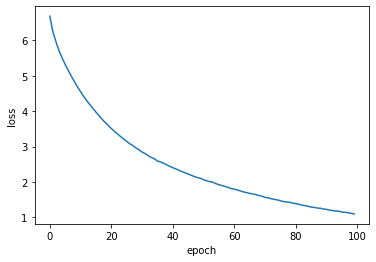

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/lstm-basic3')

In [ ]:
def generateraplyrics():
  seed_text  = random.choice(bars)
  next_words = 100
  token_list = sentence_to_integer(seed_text)
  token_list = pad_sequences([token_list], maxlen = padding_length - 1, padding = 'pre')
  predicted  = new_model.predict_classes(token_list, verbose = 0)
  lyrics = int_to_word[predicted[0]]
  for _ in range(next_words):
      token_list = sentence_to_integer(lyrics)
      token_list = pad_sequences([token_list], maxlen = padding_length - 1, padding = 'pre')
      predicted  = new_model.predict_classes(token_list, verbose = 0)
      lyrics += ' ' + int_to_word[predicted[0]]
  return lyrics.capitalize()

In [ ]:
generateraplyrics()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'Tight gun totin motherfricker see you chumps on top sky is the limit and you know that you keep on your wall you want you call it if i go to do somethin man im similar to the thriller in manila that line baby we dont want it yo a poop i love you like a lot of a intermission is a benz but he dont get with me what i gotta do is creep my frickin hunger to fight or deep wit the mental fricked in them advancing from duplex to mansion and pure poops still a part of you'